# Introduction to Target Encoding

This is an introduction to Target Encoding, exhibiting the application of K-Fold Target Encoding technique on the Titanic competition data.

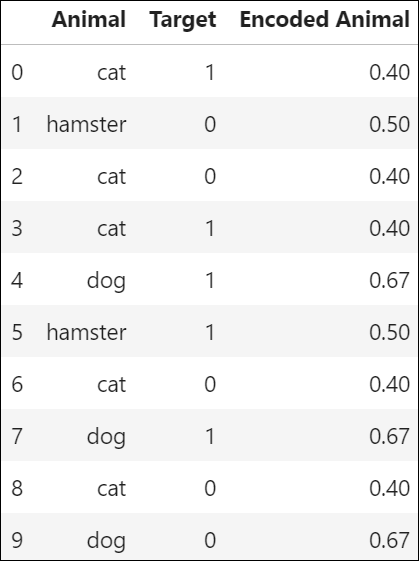

Target Encoding is similar to label encoding, except here labels are correlated directly with the target. Mean target encoding for each category in the feature label is decided with the mean value of the target variable on a training data. This encoding method brings out the relation between similar categories, but the relations are bounded within the categories and target itself. 

The advantages of the mean target encoding are that it does not affect the volume of the data and helps in faster learning. Many competition winning models make use of target encoding as it often produces higher accuracy (sometimes drastically high accuracies) because of the direct correlation between the encoded variable and the target. 

Overfitting can be a major problem while using target encoding which can be addressed by using the K-Fold Target Enoding technique.

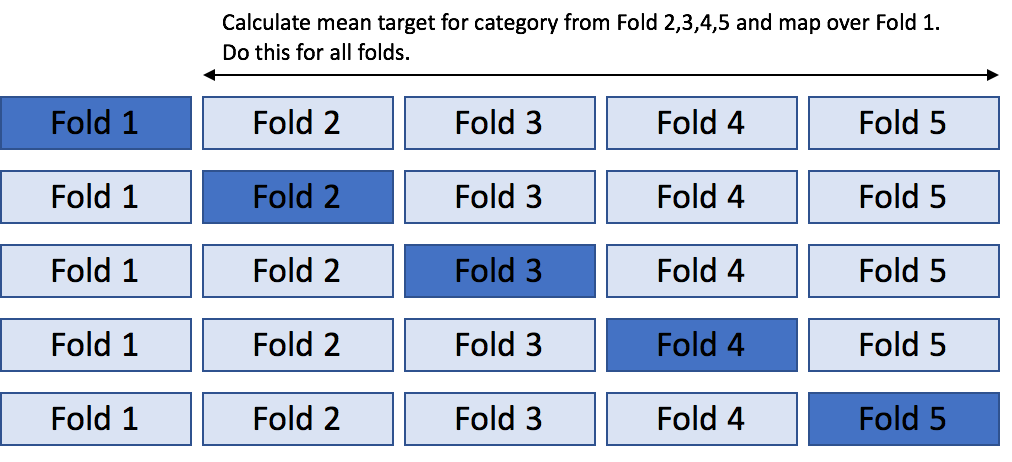

The idea is similar to k-fold cross validation. We divide the data in K-stratified or random folds, replace the observations present in the M-th fold with mean target of data from all other folds except the M-th fold. We are basically trying to use all the data given to us and not leak the information from self target label by allowing target information to flow from other fellow observations (same category but other folds).

# The Code for application

We will now apply K-Fold Target Enoding technique on the Titanic competition data by encoding the **Embarked feature** of the dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import base
from sklearn.model_selection import KFold

train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

First, a k-fold target encoder class will be created for the train set. The KFoldTargetEncoderTrain class gets the name of the feature column, target column and number of fold initially and then fit and transform the train data. 

In [ ]:
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

Now, we will create an object of this class and use it to fit and transform the train data. As mentioned earlier, we will encode the Embarked column of the dataset.

In [ ]:
targetc = KFoldTargetEncoderTrain('Embarked','Survived',n_fold=5)
new_train = targetc.fit_transform(train)

Taking a look at the new_train dataset, we can see a new column named Embarked_Kfold_Target_Enc which is the target encoded version of the Embarked feature.

In [ ]:
new_train.head()

Finally, we need to create the “Embarked_Kfold_Target_Enc” in the test dataset by using the following class. The class needs the train dataset and “Feature” ("Embarked") and the name of the encoded column. After that we fit and transform the test dataset.

In [ ]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

Now, we will create an object of this class and use it to fit and transform the test data.

In [ ]:
test_targetc = KFoldTargetEncoderTest(new_train,
                                      'Embarked',
                                      'Embarked_Kfold_Target_Enc')
new_test = test_targetc.fit_transform(test)

Taking a look at the new_test dataset, we can see a new column named Embarked_Kfold_Target_Enc which is the target encoded version of the Embarked feature.

In [ ]:
new_test.head()